In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.misc import imresize as imresize
from scipy.misc import imread as imread
from scipy.misc import imsave as imsave
import os
import glob
import pickle
import warnings
warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline

## Selecting regions that matter

In [3]:
# Apply distortion correction to raw images
# Load rawimages
folder = 'test_images/'
image_files = os.listdir(folder)
test_images = []
for i in range(len(image_files)):
    file_name  = os.path.join(folder, image_files[i])
    if file_name.endswith(".jpg"):
        image_file = imread(file_name, False, 'RGB')
        image_file = imresize(image_file, (720, 1280), interp='bilinear')  
        test_images.append(image_file)

In [4]:
test_images = np.array(test_images)
print(test_images.shape)

(6, 720, 1280, 3)


(-0.5, 1279.5, 719.5, -0.5)

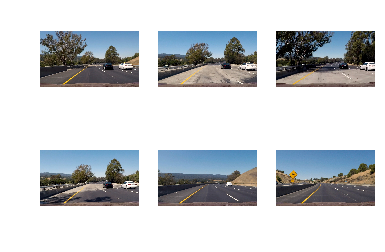

In [5]:
# Visualize Test Images:
f, ((ax1, ax2, ax3), (ax4, ax5, ax6))= plt.subplots(2, 3, sharex='col', sharey='row')

ax1.imshow(test_images[0,:,:,:])
ax1.axis('off')
ax2.imshow(test_images[1,:,:,:])
ax2.axis('off')
ax3.imshow(test_images[2,:,:,:])
ax3.axis('off')
ax4.imshow(test_images[3,:,:,:])
ax4.axis('off')
ax5.imshow(test_images[4,:,:,:])
ax5.axis('off')
ax6.imshow(test_images[5,:,:,:])
ax6.axis('off')

In [6]:
## Keep only the region, where the vechile is more likely.
cut_test_images = []

for i in range(len(test_images)):
    cut_test = test_images[i, 350:, :, :]
    cut_test_images.append(cut_test)

cut_test_images = np.array(cut_test_images)
print(cut_test_images.shape)

(6, 370, 1280, 3)


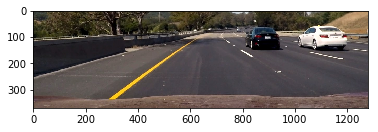

In [7]:
## Visualize the cut image
plt.imshow(cut_test_images[0,:,:,:])

## Sliding Window

In [39]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [40]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [92]:
windows = slide_window(cut_test_images[0], x_start_stop=[None, None], y_start_stop=[0, 250], 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))
                       
window_img = draw_boxes(cut_test_images[0], windows, color=(0, 0, 255), thick=6)                    

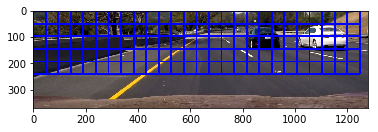

In [93]:
# Visualize the sliding window
plt.imshow(window_img)

## Obtain and organize data

In [41]:
# Get Data to train classifier
data_dict = {}

car_list = []
car_folder1 = 'datasets/vehicles'
car_folders = os.listdir(car_folder1)
car_folders = car_folders[0:-1]

for i in range(len(car_folders)):
    image_files = os.listdir(os.path.join(car_folder1, car_folders[i]))
    for j in range(len(image_files)):
        file_name  = os.path.join(car_folder1, car_folders[i], image_files[j])
        if file_name.endswith(".png"):
            image_file = imread(file_name, False, 'RGB')
            image_file = imresize(image_file, (64, 64), interp='bilinear')  
            car_list.append(image_file)
    print(str(car_folders[i]), ' Completed.')

GTI_Left  Completed.
GTI_MiddleClose  Completed.
KITTI_extracted  Completed.
GTI_Right  Completed.
GTI_Far  Completed.


In [34]:
notcar_list = []
car_folder1 = 'datasets/non-vehicles'
car_folders = os.listdir(car_folder1)
del car_folders[1]

for i in range(len(car_folders)):
    image_files = os.listdir(os.path.join(car_folder1, car_folders[i]))
    for j in range(len(image_files)):
        file_name  = os.path.join(car_folder1, car_folders[i], image_files[j])
        if file_name.endswith(".png"):
            image_file = imread(file_name, False, 'RGB')
            image_file = imresize(image_file, (64, 64), interp='bilinear')  
            notcar_list.append(image_file)
    print(str(car_folders[i]), ' Completed.')

Extras  Completed.
GTI  Completed.


In [35]:
# Define a key in data_dict "n_cars" and store the number of car images
data_dict["cars"] = car_list
data_dict["n_cars"] = notcar_list

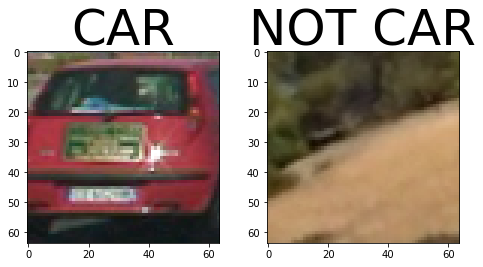

In [37]:
f, (ax1, ax2) = plt.subplots(1, 2)
f.tight_layout()
ax1.imshow(car_list[0])
ax1.set_title('CAR', fontsize=50)
ax2.imshow(notcar_list[0], cmap = 'gray')
ax2.set_title('NOT CAR', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [40]:
# Save the datasets:
pickle.dump(data_dict, open( "dataset.p", "wb" ))

## Data Curation

In [268]:
data_dict = pickle.load(open( "dataset.p", "rb" ))

In [269]:
car_list = data_dict["cars"]
notcar_list = data_dict["n_cars"] 

In [270]:
print('Training set of cars: ', len(car_list))
print('Training set of not-cars:', len(notcar_list))

Training set of cars:  8792
Training set of not-cars: 8968


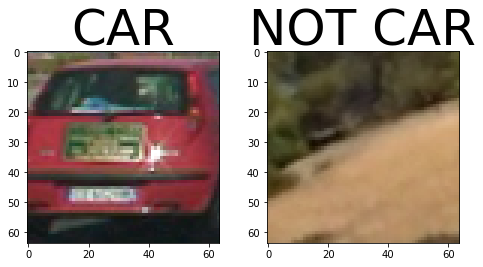

In [11]:
f, (ax1, ax2) = plt.subplots(1, 2)
f.tight_layout()
ax1.imshow(car_list[0])
ax1.set_title('CAR', fontsize=50)
ax2.imshow(notcar_list[0], cmap = 'gray')
ax2.set_title('NOT CAR', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Using SVM

In [316]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
import time

In [13]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [14]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

In [15]:
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [16]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    
    # Create a list to append feature vectors to
    features = []
    
    # Iterate through the list of images
    for img in imgs:
        #1) Define an empty list to receive features
        img_features = []
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else: 
            feature_image = np.copy(img)
            
        #3) Compute spatial features if flag is set
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            #4) Append features to list
            img_features.append(spatial_features)
        #5) Compute histogram features if flag is set
        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            #6) Append features to list
            img_features.append(hist_features)
        #7) Compute HOG features if flag is set
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))      
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            #8) Append features to list
            img_features.append(hog_features)
        
        img_features = np.concatenate(img_features)
        features.append(img_features)

    # Return list of feature vectors
    return features

In [200]:
# Reduce the sample size because HOG features are slow to compute
# The quiz evaluator times out after 13s of CPU time
sample_size = 8792
cars = car_list[0:sample_size]
notcars = notcar_list[0:sample_size]

In [277]:
color_space = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 12  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 1 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

In [278]:
car_features = np.array(car_features)
notcar_features = np.array(notcar_features)
print(car_features.shape)
print(notcar_features.shape)

(8792, 3168)
(8792, 3168)


In [279]:
X = np.vstack((car_features, notcar_features))

In [280]:
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


In [311]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=rand_state)

In [312]:
print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

Using: 12 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 3168


In [313]:
print('x_Train:', X_train.shape)
print('y_train:', y_train.shape)

x_Train: (16704, 3168)
y_train: (16704,)


In [285]:
# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
svc.fit(X_train, y_train)

# Check the prediction time for a single sample
t=time.time()

n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])

t2 = time.time()

print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

My SVC predicts:  [ 0.  1.  0.  0.  0.  1.  1.  1.  1.  0.]
For these 10 labels:  [ 0.  1.  1.  0.  0.  1.  1.  1.  1.  0.]
0.00234 Seconds to predict 10 labels with SVC


## Prediction

In [287]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    
    warnings.simplefilter("ignore")
    
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
            
    # Return the list of windows
    return window_list

In [288]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [289]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
            
    #8) Return windows for positive detections
    return on_windows

In [290]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [291]:
image = cut_test_images[1]
draw_image = np.copy(image)

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[0, 300], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
                       
hot_windows = search_windows(cut_test_images[1], windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat) 

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

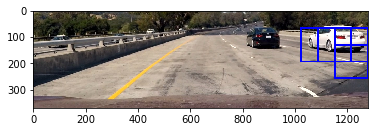

In [292]:
plt.imshow(window_img)

In [293]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [294]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

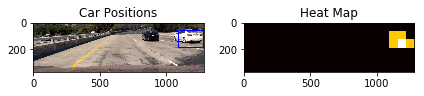

In [295]:
from scipy.ndimage.measurements import label

box_list = hot_windows

# Read in image similar to one shown above 
image = cut_test_images[1]
heat  = np.zeros_like(image[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat1 = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat1, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

In [296]:
## Multiple windows

In [303]:
image = cut_test_images[5]
draw_image = np.copy(image)

In [304]:
windows1 = slide_window(image, x_start_stop=[None, None], y_start_stop=[0, 200], 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))
windows2 = slide_window(image, x_start_stop=[None, None], y_start_stop=[0, 300], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
windows3 = slide_window(image, x_start_stop=[None, None], y_start_stop=[0, 350], 
                    xy_window=(256, 256), xy_overlap=(0.5, 0.5))

In [305]:
windows = []

windows.extend(windows1)
windows.extend(windows2)
windows.extend(windows3)


In [306]:
hot_windows = search_windows(cut_test_images[1], windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat) 

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)

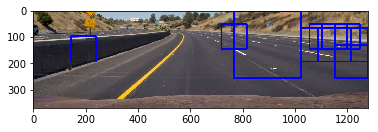

In [307]:
plt.imshow(window_img)

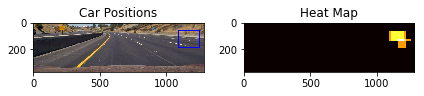

In [310]:
from scipy.ndimage.measurements import label

box_list = hot_windows

# Read in image similar to one shown above 
heat  = np.zeros_like(image[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat1 = apply_threshold(heat,2)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat1, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()